# Generic Player Position Model

## Import Required Libraries

In [17]:
# Misc libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch libraries
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Define the Neural Network Model

In [18]:
# Define a multi-class classification neural networks
class MultiClassNN(nn.Module):
    def __init__(self, input_size = 57, hidden_layers = [64, 64], output_size = 3, dropout_rate = 0.2):
        super(MultiClassNN, self).__init__()

        self.hidden_layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        # Input layer to first hidden layer
        self.hidden_layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.dropouts.append(nn.Dropout(dropout_rate))

        # Hidden layers
        for i in range(1, len(hidden_layers)):
            self.hidden_layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            self.dropouts.append(nn.Dropout(dropout_rate))

        # Output layer 
        self.output_layer = nn.Linear(hidden_layers[-1], output_size)

    def forward(self, x):
        for linear, dropout in zip(self.hidden_layers, self.dropouts):
            x = F.relu(linear(x))
            x = dropout(x)

        x = self.output_layer(x)
        x = F.softmax(x, dim = 1)

        return x

## Define the Training Loop

In [19]:
def train_model(model, train_loader, val_loader, optimizer, epochs, patience, print_epochs = False):
    # Define the loss function
    loss_function = nn.CrossEntropyLoss()

    # Initialize a previous loss value as a variable to compare validation losses to after each iteration
    previous_val_loss = float("inf")

    # Initialize loss lists and early stopping epochs
    train_losses = []
    val_losses = []
    early_stopping_epochs = 0
    
    # Iterate through epochs
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0

        # Iterate over batches in the training data
        for inputs, labels in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs.float())

            loss = loss_function(outputs, labels.long())

            # Backward pass
            loss.backward()

            # Update model parameters using the optimizer
            optimizer.step()

            # Record the loss for the batch
            running_train_loss += loss.item()
        
        # Get training loss for the epoch
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Set the model to evaluation mode
        model.eval()
        running_val_loss = 0.0

        # Disable gradient calculation for validation
        with torch.no_grad():
            # Iterate over batches in the validation data
            for inputs, labels in val_loader:
                # Forward pass
                outputs = model(inputs.float())

                loss = loss_function(outputs, labels.long())

                # Record the loss for the batch
                running_val_loss += loss.item()
        
        # Calculate the average validation loss for the epoch
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if print_epochs == True:
            print(f"Epoch {epoch + 1}: Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
        else:
            pass

        
        # Early stop if validation loss change is below tolerance
        if previous_val_loss > avg_val_loss:
            previous_val_loss = avg_val_loss
            early_stopping_epochs = 0
        else:
            early_stopping_epochs += 1

        # Break the loop if early stopping criteria is met
        if early_stopping_epochs >= patience:
            #print("Early stopping triggered.")
            break

    return train_losses, val_losses

## Define the Hyperparameter Tuning Function

In [20]:
from tqdm import tqdm

def tune_hyperparameters(train_loader, val_loader, params, epochs, patience, print_epochs = False):
    best_params = None
    best_val_loss = float("inf")
    results = []

    # Calculate total combinations
    total_combinations = (
        len(params["hidden_size"]) *
        len(params["dropout"]) *
        len(params["learning_rate"]) *
        len(params["optimizer"])
    )
    
    # Iterate over all combinations of hyperparameters
    with tqdm(total = total_combinations, desc = "Tuning") as progressbar:
        for hidden_size in tqdm(params["hidden_size"]):
            for dropout in params["dropout"]:
                for learning_rate in params["learning_rate"]:
                    for optimizer_name in params["optimizer"]:
                        # Initialize model with given parameters
                        model = MultiClassNN(hidden_layers = hidden_size, dropout_rate = dropout)

                        # Choose optimizer
                        if optimizer_name == "adam":
                            optimizer = optim.Adam(model.parameters(), lr = learning_rate)

                        elif optimizer_name == "sgd":
                            optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

                        elif optimizer_name == "rmsprop":
                            optimizer = optim.RMSprop(model.parameters(), lr = learning_rate)
                        else: 
                            continue
                        
                        # Train model with current hyperparameters
                        train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, epochs, patience, print_epochs)

                        # Get final (best) loss value for the run
                        final_train_loss = train_losses[-1] if train_losses else float("inf")
                        final_val_loss = val_losses[-1] if val_losses else float("inf")
                        
                        
                        # Store results
                        results.append({
                            "hidden_size": hidden_size,
                            "dropout": dropout,
                            "learning_rate": learning_rate,
                            "optimizer": optimizer_name,
                            "final_val_loss": final_val_loss
                        })
                        
                        # Update best parameters if a better validation loss value exists
                        if final_val_loss < best_val_loss:
                            best_val_loss = final_val_loss
                            best_params = {
                                "hidden_size": hidden_size,
                                "dropout": dropout,
                                "learning_rate": learning_rate,
                                "optimizer": optimizer_name
                            }
                    
                        # Update progress bar
                        progressbar.update(1)

                    
    
    print("Best Hyperparameters:", best_params)
    print("Best Validation Loss:", best_val_loss)
    
    return best_params, results

## Load Required Data

In [21]:
# Set pandas to show all columns
pd.set_option("display.max_columns", None)

players_df = pd.read_csv("../data/processed/players.csv")

In [22]:
players_df.head()

,short_name,overall,value_eur,wage_eur,age,height_cm,weight_kg,specific_position,weak_foot,skill_moves,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,generic_position,preferred_foot_Left,preferred_foot_Right,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium,body_type_Lean,body_type_Normal,body_type_Stocky,body_type_Unique,encoded_specific_position,encoded_generic_position
0,L. Messi,3.994363,11.773258,19.063919,0.119609,-1.795063,-1.216241,ST,-0.070558,2.179825,2.072804,2.443871,2.613576,3.141647,-1.707441,-0.606107,1.946897,2.562230,1.009902,2.680266,2.348641,2.704276,2.257895,2.573319,1.466892,3.270933,2.237848,1.773266,2.098700,3.528427,2.254043,1.355678,0.440647,0.571132,-0.735201,2.122589,-1.131758,-1.814858,2.326054,2.452623,1.693862,-1.574250,-1.848822,-1.738199,attacker,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,8,0
1,Cristiano Ronaldo,3.829447,9.161493,12.829917,0.608677,0.670171,0.734290,LW,1.448493,3.701450,2.072804,2.725796,2.113584,2.648646,-1.400920,1.264754,1.874772,2.622272,2.310772,1.894327,2.477669,2.464220,2.193190,1.875336,1.116863,2.841026,1.830877,2.107874,2.019681,3.038873,-0.286407,2.421060,2.211626,1.744535,0.878284,2.435434,-0.019059,-1.703349,2.259951,1.765144,2.375243,-1.740209,-1.312257,-1.579223,attacker,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,4,0
2,Z. Ibrahimović,3.499616,5.942340,9.267630,1.342279,2.210942,2.984903,ST,1.448493,2.179825,0.623767,2.584834,2.113584,2.155646,-1.278311,2.083255,1.369897,2.382102,1.443525,2.118881,2.800240,2.064125,1.675550,1.938789,1.466892,2.626072,0.447177,0.685789,1.466545,2.426931,-2.032966,2.344961,0.356314,0.668916,2.067168,2.122589,1.538721,-1.926367,1.929433,1.917917,2.829498,-1.574250,-0.775692,-1.367256,attacker,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,8,0
3,Iniesta,3.334701,3.937962,8.377058,0.853211,-1.640986,-1.516322,LM,1.448493,2.179825,0.538529,1.245691,2.913571,2.648646,0.254298,-0.606107,2.019022,1.301333,-0.464418,3.129374,1.638984,2.384201,1.675550,1.304259,2.604486,3.055979,0.609965,0.518485,1.229487,3.038873,1.539541,0.214197,-1.161668,0.668916,-0.820122,1.309191,-0.389958,0.749844,1.995536,2.681783,1.315317,0.195984,0.082812,0.169509,midfielder,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,3,2
4,R. van Persie,3.169785,4.484611,7.664601,0.853211,0.978325,-0.616077,ST,-0.070558,2.179825,0.453292,2.514353,2.213583,1.859846,-1.339615,-0.021463,1.730522,2.382102,1.183351,2.231158,2.800240,1.744050,2.063780,2.002242,1.379384,2.303642,0.365783,0.434833,0.992428,2.794096,-0.603963,2.116665,-0.740006,0.082214,0.283842,1.997451,-0.612498,-1.145806,2.193847,1.841530,2.450952,-1.684889,-1.258600,-1.685207,attacker,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,8,0


## Split Data into Training, Validation, and Testing Sets

In [23]:
#  Define the Target and Features columns
x = players_df.drop(columns = ["short_name", "specific_position", "generic_position", "encoded_specific_position", "encoded_generic_position"])
y = players_df["encoded_generic_position"].astype(np.float32)

all_indices = np.arange(len(players_df))

# Train-val-test split
x_train, x_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(x, y, all_indices, test_size = 0.2)
x_val, x_test, y_val, y_test, idx_val, idx_test = train_test_split(x_temp, y_temp, idx_temp, test_size = 0.5)


# Data Shape Sanity Check
print("-----SHAPES BEFORE SPLITTING-----")
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}\n")

print("-----SHAPES AFTER SPLITTING-----")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}\n")

print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}\n")

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}\n")


-----SHAPES BEFORE SPLITTING-----
x shape: (58107, 57)
y shape: (58107,)

-----SHAPES AFTER SPLITTING-----
x_train shape: (46485, 57)
y_train shape: (46485,)

x_val shape: (5811, 57)
y_val shape: (5811,)

x_test shape: (5811, 57)
y_test shape: (5811,)



## Normalize Data

In [24]:
# Scale features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)
x_test = scaler.transform(x_test)

## Create Dataloaders

In [25]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype = torch.float32)
x_val_tensor = torch.tensor(x_val, dtype = torch.float32)
x_test_tensor = torch.tensor(x_test, dtype = torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype = torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype = torch.float32)

# Create datasets and dataloaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

## Tune Hyperparameters

In [27]:
# Define hyperparameter grid
params = {
    "hidden_size": [[128, 128, 128], [256, 256, 256]],
    "dropout": [0.3, 0.4],
    "learning_rate": [0.0001, 0.001],
    "optimizer": ["adam", "sgd", "rmsprop"]
}

epochs = 30
patience = 3
print_epochs = False

# Run hyperparameter tuning
best_params, tuning_results = tune_hyperparameters(train_loader, val_loader, params, epochs, patience, print_epochs)

Tuning: 100%|██████████| 24/24 [55:40<00:00, 139.19s/it]

Best Hyperparameters: {'hidden_size': [256, 256, 256], 'dropout': 0.4, 'learning_rate': 0.0001, 'optimizer': 'adam'}
Best Validation Loss: 0.6763764442978325


## Plot the Training and Validation Loss Curves for the Optimal Model

Epoch 1: Training Loss: 0.7551 | Validation Loss: 0.6933
Epoch 2: Training Loss: 0.6990 | Validation Loss: 0.6875
Epoch 3: Training Loss: 0.6944 | Validation Loss: 0.6841
Epoch 4: Training Loss: 0.6913 | Validation Loss: 0.6830
Epoch 5: Training Loss: 0.6898 | Validation Loss: 0.6815
Epoch 6: Training Loss: 0.6880 | Validation Loss: 0.6822
Epoch 7: Training Loss: 0.6866 | Validation Loss: 0.6807
Epoch 8: Training Loss: 0.6859 | Validation Loss: 0.6808
Epoch 9: Training Loss: 0.6850 | Validation Loss: 0.6804
Epoch 10: Training Loss: 0.6837 | Validation Loss: 0.6790
Epoch 11: Training Loss: 0.6838 | Validation Loss: 0.6789
Epoch 12: Training Loss: 0.6829 | Validation Loss: 0.6782
Epoch 13: Training Loss: 0.6820 | Validation Loss: 0.6780
Epoch 14: Training Loss: 0.6820 | Validation Loss: 0.6773
Epoch 15: Training Loss: 0.6808 | Validation Loss: 0.6770
Epoch 16: Training Loss: 0.6798 | Validation Loss: 0.6770
Epoch 17: Training Loss: 0.6799 | Validation Loss: 0.6770
Epoch 18: Training Loss

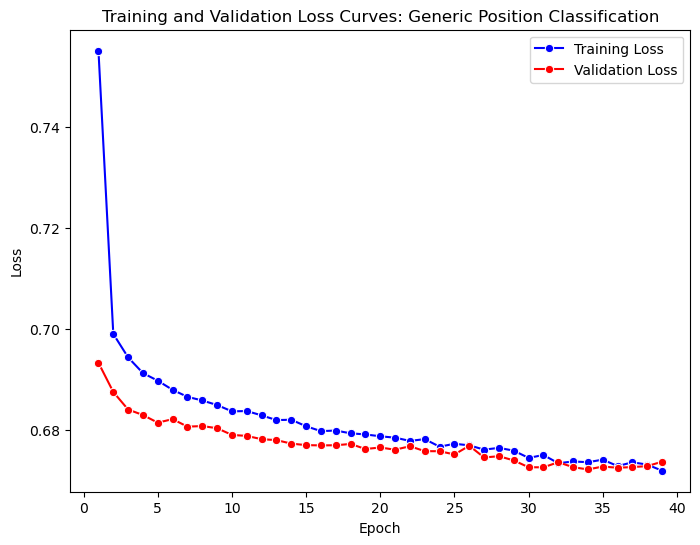

In [33]:
best_params = {
    "hidden_size": [256, 256, 256],
    "dropout": 0.4,
    "learning_rate": 0.0001,
    "optimizer": "adam"
}

# Intialize the model with the tuned optimal parameters
model = MultiClassNN(input_size = 57, hidden_layers = best_params["hidden_size"], output_size = 3, dropout_rate = best_params["dropout"])

# Identify the optimal optimizer
if best_params["optimizer"] == "adam":
    optimizer = optim.Adam(model.parameters(), lr = best_params["learning_rate"])

elif best_params["optimizer"] == "sgd":
    optimizer = optim.SGD(model.parameters(), lr = best_params["learning_rate"], momentum = 0.9)
    
elif best_params["optimizer"] == "rmsprop":
    optimizer = optim.RMSprop(model.parameters(), lr = best_params["learning_rate"])


# Determine number of epochs and specify model type
epochs = 100
patience = 5
print_epochs = True


# Train the optimal model
train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, epochs, patience, print_epochs)


# Plot training and validation losses after all epochs are finished
plt.figure(figsize = (8, 6))
sns.lineplot(x = range(1, len(train_losses) + 1), y = train_losses, label = "Training Loss", marker = "o", linestyle = "-", color = "blue")
sns.lineplot(x = range(1, len(val_losses) + 1), y = val_losses, label = "Validation Loss", marker = "o", linestyle = "-", color = "red")
plt.title("Training and Validation Loss Curves: Generic Position Classification")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.savefig("../img/generic_position_loss_curves.png", dpi = 300, bbox_inches = "tight")

plt.show()

## Evaluate the Test Set

In [34]:
# Set model to evaluation mode
model.eval()

# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Initialize variables for tracking loss and predictions
test_loss = 0.0
all_preds = []
all_labels = []
all_probs = []

# No gradient calculation during testing
with torch.no_grad():

    # Iterate over the test set
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model(inputs.float())

        # Calculate loss
        loss = loss_function(outputs, labels.long())
        test_loss += loss.item()
        
        # Get predicted class by taking the index of the max log-probability
        preds = torch.argmax(outputs, dim = 1)

        # Store softmax probabilities for ROC
        probs = torch.softmax(outputs, dim = 1)
        all_probs.extend(probs.cpu().numpy())
        
        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Average test loss
avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss}")

Test Loss: 0.6714916648445549


## Save the Model

In [35]:
# Save the model
torch.save(model.state_dict(), "../models/generic_position_model.pt")

## Display Model Prediction Metrics

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Compute classification metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average = "weighted")
recall = recall_score(all_labels, all_preds, average = "weighted")
f1 = f1_score(all_labels, all_preds, average = "weighted")

# Print classification metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print(classification_report(all_labels, all_preds, digits = 4))

# Select the rows from the original DataFrame corresponding to the test set
test_df = players_df.iloc[idx_test].reset_index(drop = True) 

# Define the mapping
position_map = {
    0: "Attacker",
    1: "Defender",
    2: "Midfielder"
}

# Convert numeric predictions to position labels
mapped_preds = [position_map[p] for p in all_preds]

# Log predictions
test_results = pd.DataFrame({
    "actual": all_labels,
    "prediction": mapped_preds
})

# Merge with selected player features
final_results_df = pd.concat([
    test_df[["short_name", "generic_position"]].reset_index(drop = True),
    test_results
], axis = 1)


final_results_df.drop(columns = ["actual"], inplace = True)

final_results_df["generic_position"] = final_results_df["generic_position"].str.capitalize()
final_results_df = final_results_df.rename(columns = {"generic_position": "Actual Position", "short_name": "Player Name", "prediction": "Predicted Position"})

final_results_df.to_csv("../data/results/generic_position_predictions.csv", index = False)

final_results_df.head(10)

Accuracy: 0.8776
Precision: 0.8772
Recall: 0.8776
F1 Score: 0.8766
              precision    recall  f1-score   support

         0.0     0.8440    0.7328    0.7845      1048
         1.0     0.9316    0.9456    0.9385      2406
         2.0     0.8365    0.8727    0.8542      2357

    accuracy                         0.8776      5811
   macro avg     0.8707    0.8504    0.8591      5811
weighted avg     0.8772    0.8776    0.8766      5811



,Player Name,Actual Position,Predicted Position
0,R. Slater,Midfielder,Midfielder
1,V. Ćorluka,Defender,Defender
2,J. Egan,Defender,Defender
3,Júlio César,Defender,Defender
4,H. Ishihara,Defender,Midfielder
5,Claudiosa Paes,Midfielder,Midfielder
6,E. López,Midfielder,Midfielder
7,Dante,Defender,Defender
8,A. Doucouré,Midfielder,Midfielder
9,P. Polomat,Defender,Defender


## Confusion Matrix

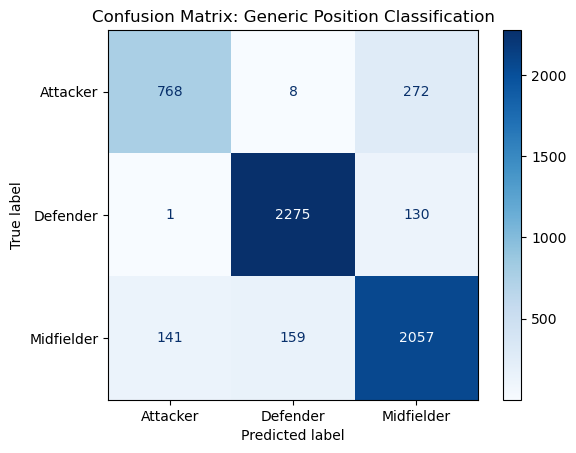

In [39]:
# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Attacker", "Defender", "Midfielder"])
cm_display.plot(cmap = "Blues")
plt.title("Confusion Matrix: Generic Position Classification")

plt.savefig("../img/generic_position_confusion_matrix.png", dpi = 300, bbox_inches = "tight")

plt.show() 
